# Step 2: Make a simulation
First, you will have to make a few choices: 
* Choose a simple mass model (ex. SIE)
* Choose a light model (ex. SERSIC_ELLIPSE)

The simulation should output what you can measure from your data. For us, we should get: 
* Image positions
* Lens position(s)

We will set these to be similar to our data
* fwhm & psf model
* background_rms
* theta_E
* source position

I found it to be a good exercise to mess around with the simulation until I found a similar looking geometry to the candidate I was trying to model, but that is definitely optional!

In [4]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import corner
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import param_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.lens_plot import lens_model_plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [5]:
# from our 'data'
exp_time = 90.
deltaPix = 0.2637
numPix = 46
psf_type = 'GAUSSIAN'
fwhm = 1  # close to our r-band
background_rms = 4  # also close to r-band

In [10]:
# choose parameters (these were chosen for simplicity)
# einstein radius
theta_E = 2

# source position
ra_source = 0 
dec_source = 0

# lens position
center_x = 0
center_y = 0

# ellipticity of the lens
e1 = -0.1
e2 = 0.1

ra_images=[ 1.92356475 -1.92356475 -0.72471216  0.72471216]
dec_images=[-0.79676661  0.79676661 -1.74960994  1.74960994]


/var/folders/6n/b2_b03_d65dc17frrw6ryn640000gn/T/ipykernel_49730/2142057254.py:75: RuntimeWarning: invalid value encountered in log10
  ax[0].matshow(np.log10(image_sim), origin='lower')


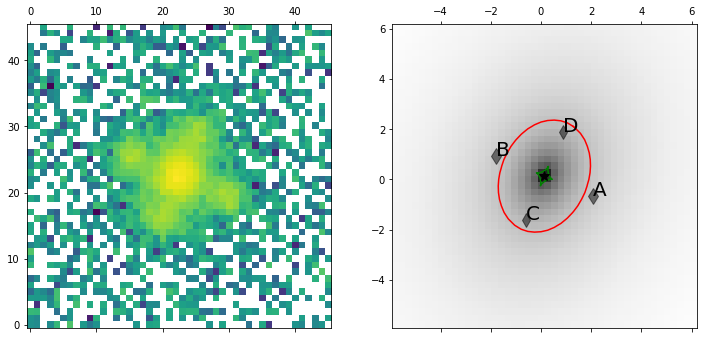

In [11]:
# Simulate data: 
# set data model
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)

# set the PSF model
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
psf_class = PSF(**kwargs_psf)

# Model choices
# LIGHT
light_model_list = ['SERSIC_ELLIPSE']  # choice of light model
lightModel = LightModel(light_model_list=light_model_list)  # set light model class
lens_light = {'amp': 400, 'R_sersic': 1., 'n_sersic': 2,
                'center_x': center_x, 'center_y': center_y, 'e1': e1, 'e2': e2} # set light parameters
kwargs_lens_light = [lens_light]  # if multiple lenses, add multiple {lens_light}s to kwargs_lens_light

# MASS
lens = {'theta_E': theta_E, 'center_x': center_x, 'center_y': center_y, 'e1': e1, 'e2': e2}
kwargs_lens = [lens]  # if multiple lenses, add multiple {lens}s to kwargs_lens
lens_model_list=['SIE']  # choice of mass model
lens_model_class = LensModel(lens_model_list=lens_model_list)  # set lens mass class

# SOURCE
# from our real data, we cannot measure the source position, only the image positions
# so we will calculate image positions from a chosen source here:
lensEquationSolver = LensEquationSolver(lens_model_class)  # set lens equation solver class
source_model_list = light_model_list  # use the same light model for the source
ra_images, dec_images = lensEquationSolver.image_position_from_source(ra_source, dec_source,
                                                                 kwargs_lens, solver='lenstronomy')

print(f'ra_images={ra_images}') # print the image positions in arcsec
print(f'dec_images={dec_images}')


# compute point source magnification
mag = lens_model_class.magnification(ra_images, dec_images, kwargs=kwargs_lens)
point_amp = np.abs(mag)* 100  # convert magnitude to amplitude

# source model
# use LENSED_POSITION for model when using image positions not source position
kwargs_ps = [{'ra_image': ra_images, 'dec_image': dec_images, 'point_amp': point_amp}]
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list,
                                 fixed_magnification_list=[False])

# Image Settings
# numerics
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

# combine all classes and settings into Image Model class
imageModel = ImageModel(data_class, psf_class,
                        lens_model_class = lens_model_class,
                        point_source_class=point_source_class,
                        lens_light_model_class=lightModel,
                        kwargs_numerics=kwargs_numerics)

# simulate the image using all our inputs from above
image_sim = imageModel.image(kwargs_lens=kwargs_lens,
                             kwargs_lens_light=kwargs_lens_light,
                             kwargs_ps=kwargs_ps)

# add background noise:
poisson = image_util.add_poisson(image_sim, exp_time=exp_time) 
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms) 
image_sim = image_sim + bkg + poisson  # update image with background noise

# set image data to our simulated image
kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

# show image with critical curves and caustics
f, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].matshow(np.log10(image_sim), origin='lower')

# Plot critical curves and caustics
kwargs_lens_plot = {'with_caustics': True, 
                    'fast_caustic': True, 
                    'point_source': True,
                    'with_convergence': True,
                    'numPix': numPix,
                    'deltaPix': deltaPix,
                    'coord_inverse': False} 

lens_model_plot(ax[1],
                lens_model_class, kwargs_lens, 
                sourcePos_x=ra_source,
                sourcePos_y=dec_source,
                **kwargs_lens_plot)

plt.show()
plt.close()

Done! You can continue to mess around with the parameters chosen at the beginning until you get something that looks similar to your candidate, or you can move on to the next notebook, Step 3: Making a Model